In [1]:
#Library Used
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt

seed = 2019
np.random.seed(seed)
%matplotlib inline

In [2]:
#Dosyanın Konumu
path  = '/mnt/Disk2/rscbjbr9sj-2/OCT2017/'
train = path + 'train/'
test  = path + 'test/'
path,train,test

('/mnt/Disk2/rscbjbr9sj-2/OCT2017/',
 '/mnt/Disk2/rscbjbr9sj-2/OCT2017/train/',
 '/mnt/Disk2/rscbjbr9sj-2/OCT2017/test/')

In [3]:
#Data Augmentation
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(zoom_range = 0.4,
                                   horizontal_flip = True
                                   )
test_datagen = ImageDataGenerator()

In [4]:
#Görüntüleri Aktarma

train_gen = train_datagen.flow_from_directory(
                            directory = train, 
                            target_size = (160, 160), 
                            batch_size = 16, 
                            class_mode = 'categorical', 
                            shuffle=True)

test_gen = train_datagen.flow_from_directory(
                            directory = test, 
                            target_size = (160, 160), 
                            batch_size = 16, 
                            class_mode = 'categorical', 
                            shuffle=True)


Found 83484 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


In [5]:
train_gen[0][0].shape

(16, 160, 160, 3)

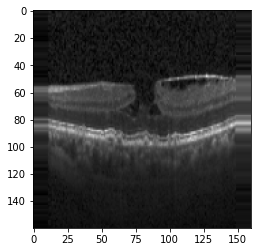

In [6]:
plt.imshow(train_gen[0][0][15]/255)

In [7]:
#Callbacks
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=2, mode='max')
cp = ModelCheckpoint(filepath='eff_model.{epoch:02d}-{val_loss:.2f}.h5',save_weights_only=True)

In [8]:
pip install git+https://github.com/qubvel/segmentation_models

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-jqrw1ux7
  Running command git clone --filter=blob:none -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-jqrw1ux7
  Resolved https://github.com/qubvel/segmentation_models to commit 94f624b7029deb463c859efbd92fa26f512b52b8
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [12]:
from tensorflow.keras.applications import * #Efficient Net included here
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import pandas as pd
from sklearn import model_selection
from tqdm import tqdm
from tensorflow.keras import optimizers
import tensorflow as tf

In [13]:
model = Sequential()
model.add(EfficientNetB5(weights='imagenet',include_top=False, input_shape=(160,160,3)))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4,activation = 'softmax'))

115277824/115263384 [==============================] - 10s 0us/step


In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics= ['accuracy'])

In [15]:
history_eff = model.fit(
           train_gen, steps_per_epoch=train_gen.samples/16, 
           epochs=5,        
           validation_data=test_gen, 
           validation_steps=test_gen.samples // 16,
           callbacks=[lr, cp],
           verbose=1)

Epoch 1/5
5217/5217 [==============================] - 37280s 7s/step - loss: 0.2852 - accuracy: 0.9082 - val_loss: 0.0833 - val_accuracy: 0.9768
Epoch 2/5
5217/5217 [==============================] - 65518s 13s/step - loss: 0.2007 - accuracy: 0.9345 - val_loss: 0.3411 - val_accuracy: 0.8659
Epoch 3/5
5217/5217 [==============================] - 73922s 14s/step - loss: 0.1786 - accuracy: 0.9423 - val_loss: 0.0173 - val_accuracy: 0.9970
Epoch 4/5
5217/5217 [==============================] - 43578s 8s/step - loss: 0.1612 - accuracy: 0.9470 - val_loss: 0.0807 - val_accuracy: 0.9738
Epoch 5/5
5217/5217 [==============================] - 43633s 8s/step - loss: 0.1495 - accuracy: 0.9505 - val_loss: 0.0691 - val_accuracy: 0.9778


In [16]:
history = history_eff

Text(0.5, 0, 'epoch')

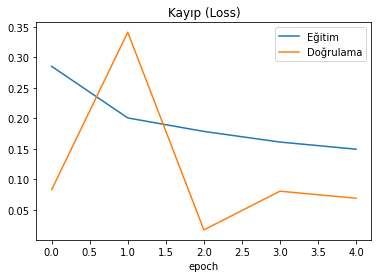

In [17]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Eğitim','Doğrulama'])
plt.title('Kayıp (Loss)')
plt.xlabel('epoch')

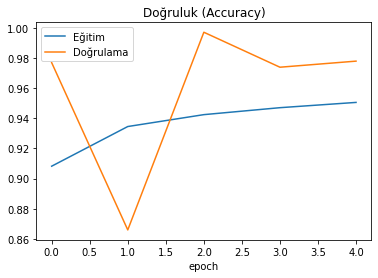

In [18]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Eğitim','Doğrulama'])
plt.title('Doğruluk (Accuracy)')
plt.xlabel('epoch')
plt.show()

In [20]:
dosya = os.listdir(path+'train//')

In [24]:
test_data = []
test_labels = []

for name in dosya:
    for img in os.listdir(test + name + '//'):
        img = plt.imread(test + name + '//' + img)
        img = cv2.resize(img, (160, 160))
        img = np.dstack([img, img, img])
        img = img.astype('float32')
        
        if   name =='CNV':
            label = 0
        elif name =='DME':
            label = 1
        elif name =='DRUSEN':
            label = 2
        elif name =='NORMAL':
            label = 3
            
        test_data.append(img)
        test_labels.append(label)
        


In [25]:
test_data[0].shape

(160, 160, 3)

In [26]:
x_test=np.asarray(test_data)

In [27]:
x_test.shape

(1000, 160, 160, 3)

In [29]:
y_test=np.asarray(test_labels)

In [30]:
y_test.shape

(1000,)

In [ ]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
y_predict = np.argmax(model.predict(x_test), axis=-1)

In [35]:
y_true=y_test
y_pred=np.argmax(model.predict(x_test), axis=-1)
y_probas=model.predict(x_test)

In [36]:
y_true[0],y_pred[0],y_probas[0]

(2,
 2,
 array([6.1274450e-03, 2.2042754e-05, 9.9365532e-01, 1.9523688e-04],
       dtype=float32))

<AxesSubplot:>

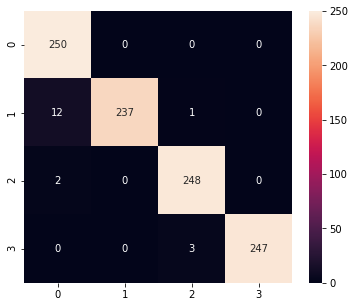

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6,5))
sns.heatmap(cm,fmt='.4g', annot=True)

In [43]:
pip install scikit-plot

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [45]:
import scikitplot as skplt


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

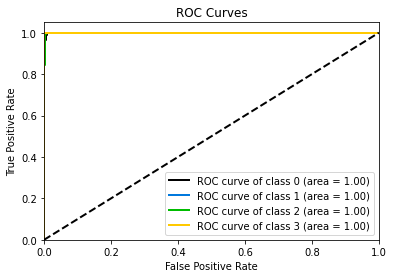

In [47]:
skplt.metrics.plot_roc(y_true,y_probas,plot_micro=False,plot_macro=False)